In [24]:
import numpy as np
import torch.nn as nn
import torch
import seaborn as sns
import pandas as pd
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset,DataLoader
from scipy.io import loadmat
from datetime import datetime
from tqdm.auto import trange,tqdm
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error
import os
import os.path as osp
import random

def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

setup_seed(12)
plt.style.use("seaborn-paper")
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #正常显示负号

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_21108\2984315300.py:29: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-paper")


In [25]:
import  torch

In [26]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)
        
    return np.array(x), np.array(y)


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break

    return abs(true_re - pred_re)/true_re


def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name][1]
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v[1], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


In [27]:
battey_capacity = dict()
keys = ["B0005","B0006","B0007","B0018"]
for k in keys:
    df = pd.read_csv(f"{k}.csv")
    battey_capacity[k] = [df['循环次数'].values.tolist(),df["容量"].values.tolist()]

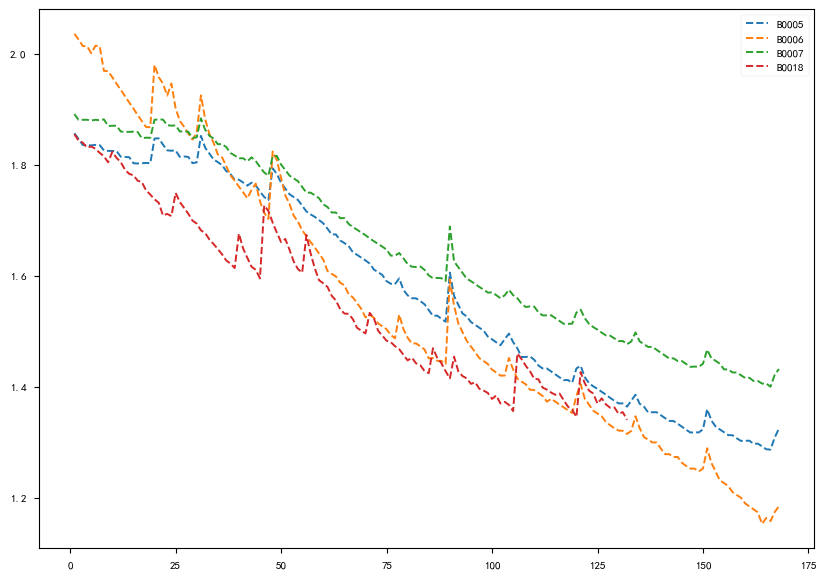

In [28]:
plt.figure(figsize = (10,7))
for key in battey_capacity:
    x,y = battey_capacity[key]
    plt.plot(x,y,"--",label = key)
plt.legend()
plt.show()

In [29]:
class CNN(nn.Module):

    def __init__(self, feature_in, feature_out):
        super(CNN, self).__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv1d(feature_in, 64, 5, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv1d(64, feature_out, 5, padding=2),
            nn.BatchNorm1d(feature_out),
            nn.ReLU(),
            nn.MaxPool1d(2)
        )

    def forward(self, x):
        x = x.permute(0, 2 , 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = x.permute(0, 2, 1)
        return x

class CNN1d(nn.Module):
    def __init__(self,in_ch):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_ch,32,3,1,1),
            nn.ReLU(),
            nn.Conv1d(32,64,3,1,1),
            nn.Dropout(0.2),
            nn.ReLU(),
            nn.Conv1d(64,64,3,1,1),
            nn.ReLU(),
            #nn.BatchNorm1d(128),
            nn.AdaptiveAvgPool1d(2)
        )
        
        self.fc  = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128,1)
        )
    def forward(self,x):
        x = self.cnn(x)
        x = x.reshape(x.size()[0],-1)
        #Aprint(x.shape)
        return torch.sigmoid(self.fc(x))
    
    
class CNN_LSTM(nn.Module):

    def __init__(self, feature_in,in_c = 10):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_c,32,3,1,1),
            nn.ReLU(),
            nn.Conv1d(32,64,3,1,1),
            nn.ReLU()
        )
        self.lstm = nn.LSTM(input_size=5, hidden_size=50, dropout=0.3,num_layers=1, batch_first=True, bidirectional=False)
    
        self.fc_out = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(50, 1)
        )

    def forward(self, x):
        x = self.cnn(x)
        x, (h, c) = self.lstm(x)
        x = torch.mean(x,dim=1)
        x = self.fc_out(x)
        return x

In [30]:
class LSTM(nn.Module):
    def __init__(self,feature_in):
        super().__init__()
        self.lstm = nn.LSTM(input_size=feature_in,
                            hidden_size=50, 
                            num_layers=1,
                            batch_first=True,
                            bidirectional=False)
        self.fc   = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(50,1)
        
        )
    def forward(self,x):
        x, (h, c) = self.lstm(x)
        x = x[:,-1,:]
        x = x.reshape(x.size()[0],-1)
        return self.fc(x)

In [31]:
class CNN_GRU(nn.Module):
    def __init__(self, feature_in):
        super().__init__()
        self.cnn = CNN(feature_in=feature_in, feature_out=128)
        self.gru = nn.GRU(input_size=128, hidden_size=256, num_layers=1, batch_first=True, bidirectional=False)
    
        self.fc_out = nn.Sequential(
            nn.Linear(256, 1)
        )

    def forward(self, x):
        x = self.cnn(x)
        x, h = self.gru(x)
        x = x[:, -1, :]
        x = self.fc_out(x)
        return x

In [32]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = np.sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse

In [33]:
def createXY(dataset,n_past):
    dataX = []
    dataY = []
    for i in range(n_past,len(dataset)):
        dataX.append(dataset[i - n_past:i,0:dataset.shape[1]])
        dataY.append(dataset[i,4])
    return np.array(dataX),np.array(dataY).reshape(-1,1)

In [34]:
def read_csv(path):
    try:
        df = pd.read_csv(key + ".csv",encoding="gbk")
    except:
        df = pd.read_csv(key + ".csv",encoding="utf-8")
    df.columns = ["循环次数","平均放电电压","平均放电温度","等压降放电时间","容量"]
    return  df

In [35]:
class Identity:
    def fit_transform(self,x):
        return x.values
    def inverse_transform(self,x):
        return x
    
    def transform(self,x):
        return x.values

In [36]:
from tqdm.auto import tqdm
from torch.utils.data import TensorDataset,DataLoader
def train_pipeline(key,model,lr=0.001,epochs = 1000,title="",step_size=10):
    try:
        df = pd.read_csv(key + ".csv",encoding="gbk")
    except:
        df = pd.read_csv(key + ".csv",encoding="utf-8")
        
    #step_size  = 5
    test_split = int(0.8 * len(df))
    #df_for_training=pd.concat([df[:test_split]] + [read_csv(pth) for pth in another_pths])
    df_for_training = df[:test_split]
    #print([df[:test_split]] + [read_csv(pth) for pth in another_pths])
    df_for_testing=df[0:]
    scaler = MinMaxScaler(feature_range=(0,1))
    df_for_training_scaled = scaler.fit_transform(df_for_training)
    df_for_testing_scaled = scaler.transform(df_for_testing)
    lossfun   = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(),lr = lr,weight_decay=1e-8,eps = 1e-8) 
    trainX , trainY = createXY(df_for_training_scaled,step_size)
    testX , testY = createXY(df_for_testing_scaled,step_size)
    print(trainX.shape,trainY.shape,testX.shape,testY.shape)
    dataset = TensorDataset(torch.FloatTensor(trainX),
                            torch.FloatTensor(trainY))
    loader  = DataLoader(dataset,batch_size=20,shuffle = True,pin_memory=True)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model  = model.to(device)
    bar = tqdm(range(epochs))
    best_loss = 1e10
    for epoch in bar:
        tot_loss = []
        for data,label in loader:
            out = model(data.to(device))
            loss= lossfun(out,label.to(device))
        
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tot_loss.append(loss.item())
        loss = np.mean(tot_loss)
        with torch.no_grad():
            y_pred = model(torch.FloatTensor(testX).to(device))
        
        mse,rmse = evaluation(y_test=testY.flatten(),y_predict=y_pred.detach().cpu().numpy().flatten())
        
        bar.set_postfix(
            {
                "mse" : round(mse,5),
                "rmse": round(rmse,5),
                "loss" : round(loss.item(),5)
            }
        )
        if mse < best_loss:
            best_loss = mse
            torch.save(model.state_dict(),"best.pt")
    model.load_state_dict(torch.load("best.pt"))

    try:
        df = pd.read_csv(key + ".csv",encoding="gbk")
    except:
        df = pd.read_csv(key + ".csv",encoding="utf-8")
    df_scaler1 = scaler.transform(df)
    #print(df_scaler1)
   # scaler_arrary = df_scaler.values
    true = df_scaler1[79 : ,4]
    predicts = []
    for i in range(79,len(df)):
        tensor = df_scaler1[i - step_size : i].reshape(1,step_size,5)
        with torch.no_grad():
            predict = model(torch.FloatTensor(tensor).to(device))    
        df_scaler1[i,4] = predict.detach().cpu().numpy().flatten()
        predicts.append(df_scaler1[i,4])
        
    df_scaler1 = scaler.inverse_transform(df_scaler1)
    n = len(df)
    plt.title(title)
    plt.plot(range(n),df["容量"],color="orange",label = "真实值")
    plt.plot(range(79,n),df_scaler1[79:,4],color="blue",label = "预测值")
    plt.legend()
    predicts = df_scaler1[79:,4]
    true     = df.values[79 :,4]
    
    #return predicts,true
    return {
        "MAE" : mean_absolute_error(true,predicts),
        "RMSE" : np.sqrt(mean_squared_error(true,predicts)) ,
        "RE"  : relative_error(true,predicts,0.7)
    }

In [37]:
root = r"./LSTM多变量时间序列预测锂电池/"

## CNN

FileNotFoundError: [Errno 2] No such file or directory: './LSTM多变量时间序列预测锂电池/B0005.csv'

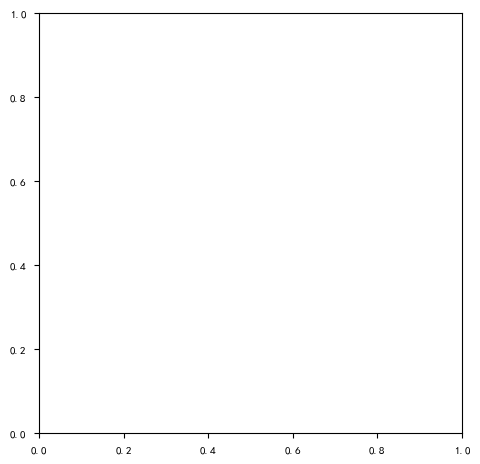

In [38]:
keys = ["B0005","B0007","B0006","B0018"]
plt.figure(figsize = (12,12))
resultcnn = {}
for i,k in enumerate(keys):
    plt.subplot(2,2,i + 1)
    # another = ["B0005","B0007","B0006","B0018"]
    # another.remove(k)
    resultcnn[k] = train_pipeline(osp.join(root,k),CNN1d(10),lr = 0.0005,epochs=4000,title = "CNN 在{}数据集的预测结果".format(k))
plt.savefig("cnn.pdf",bbox_inches='tight')
plt.show()

In [ ]:
import pandas as pd
def convert_pandas(result):
    df = pd.DataFrame(
        {
            "MAE" : [v["MAE"] for v in result.values()],
            "RMSE" : [v["RMSE"] for v in result.values()],
            "RE"  : [v["RE"] for v in result.values()],
        }
    )
    df.index = list(result.keys())
    return df
print("CNN Result")
dfcnn = convert_pandas(resultcnn)
dfcnn

In [ ]:
import pandas as pd
def convert_pandas(result):
    df = pd.DataFrame(
        {
            "MAE" : [v["MAE"] for v in result.values()],
            "RMSE" : [v["RMSE"] for v in result.values()],
            "RE"  : [v["RE"] for v in result.values()],
        }
    )
    df.index = list(result.keys())
    return df
print("CNN Result")
dfcnn = convert_pandas(resultcnn)
dfcnn

In [ ]:
dfcnn.describe()

## CNN-LSTM

In [ ]:
plt.figure(figsize = (12,12))
resultcnn_lstm = {}
for i,k in enumerate(keys):
    plt.subplot(2,2,i + 1)
    resultcnn_lstm[k] = train_pipeline(osp.join(root,k),CNN_LSTM(10),lr = 1e-3,epochs=4000,title = "CNN-LSTM 在{}数据集的预测结果".format(k))
plt.savefig("cnn_lstm.pdf",bbox_inches='tight')
plt.show()

In [ ]:
dfcnn_lstm = convert_pandas(resultcnn_lstm)
dfcnn_lstm

In [ ]:
dfcnn_lstm.describe()